<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_12_Weights_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xavier & Kaiming Initializations

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# Create a DL Model: We just care for initialization here
class thenet(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(100, 100)

        # hidden layers
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)

        # Output Layer
        self.output = nn.Linear(100, 2)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.output(x)

In [3]:
# create an instance
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


## Kaiming Initialization (Default)

In [4]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if "bias" in p[0]:
        allbiases = np.concatenate((allbiases, p[1].data.numpy().flatten()), axis=0)
    elif "weight" in p[0]:
        allweight = np.concatenate((allweight, p[1].data.numpy().flatten()), axis=0)

# Check the number for each case
print(f"There are {len(allbiases)} bias parameters in the model")
print(f"There are {len(allweight)} weight parameters in the model")
print(f"Biases represent {100*len(allbiases)/len(allweight)}% of total number of weights")

There are 402 bias parameters in the model
There are 40200 weight parameters in the model
Biases represent 1.0% of total number of weights


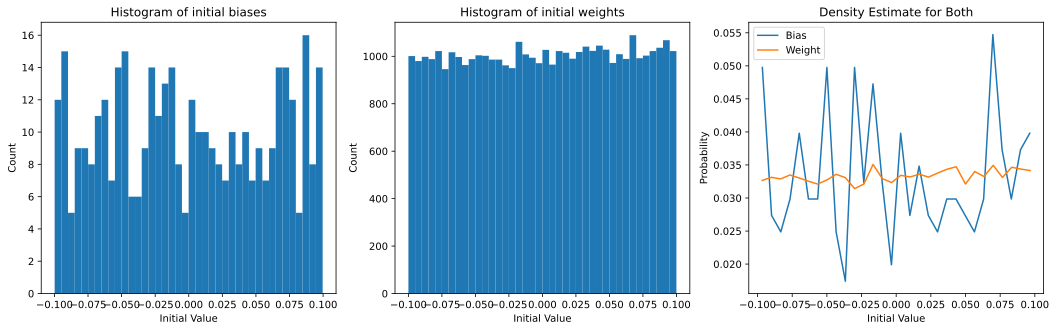

In [5]:
# Create their histograms
fig, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].hist(allbiases, 40)
ax[0].set_title("Histogram of initial biases")

ax[1].hist(allweight, 40)
ax[1].set_title("Histogram of initial weights")

# Collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2, yB/np.sum(yB), label="Bias")
ax[2].plot((xW[1:]+xW[:-1])/2, yW/np.sum(yW), label="Weight")
ax[2].set_title("Density Estimate for Both")
ax[2].legend()

# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial Value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")

plt.show()

### Layer-Specific Distributions

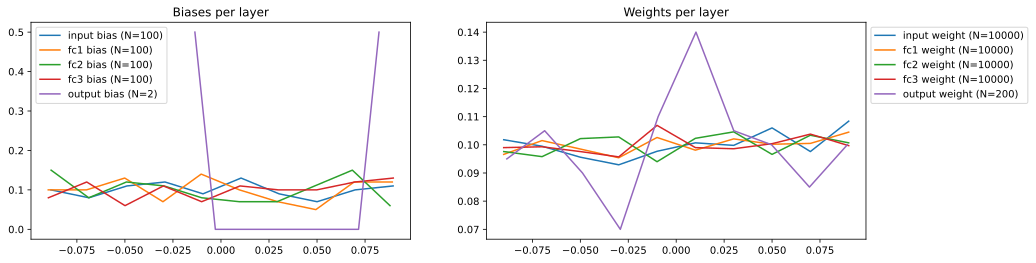

In [6]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():
    # get the data and compute their histogram
    thesedata = p[1].data.numpy().flatten()
    y,x = np.histogram(thesedata,10)

    # for the bias
    if 'bias' in p[0]:
        ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

    # for the weights
    elif 'weight' in p[0]:
        ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [7]:
# Output has only 2 datapoints, thus it is weird
print(net.output.bias.data)

tensor([-0.0189,  0.0876])


In [8]:
# Let's see whether the numbers match our predictions from formula
# Empirical bias range
biasrange = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
biascount = len(net.fc1.bias.data)

# Theoretical expected value
sigma = np.sqrt(1/biascount)

print(f"Theoretical Sigma: {sigma}")
print(f"Empirical Range: {biasrange}")

Theoretical Sigma: 0.1
Empirical Range: [-0.09985210001468658, 0.09914062172174454]


## Xavier Initialization

In [9]:
# Create a new model instance
net = thenet()

# Change the weights: leave biases default (Kaiming)
# This is not how its done, we are doing it here for illustrative purposes only
for p in net.named_parameters():
    if "weight" in p[0]:
        # The function operates in place (_), no need to reassign
        nn.init.xavier_normal_(p[1].data)

In [10]:
# Use the code from above to visualize
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if "bias" in p[0]:
        allbiases = np.concatenate((allbiases, p[1].data.numpy().flatten()), axis=0)
    elif "weight" in p[0]:
        allweight = np.concatenate((allweight, p[1].data.numpy().flatten()), axis=0)

# Check the number for each case
print(f"There are {len(allbiases)} bias parameters in the model")
print(f"There are {len(allweight)} weight parameters in the model")
print(f"Biases represent {100*len(allbiases)/len(allweight)}% of total number of weights")

There are 402 bias parameters in the model
There are 40200 weight parameters in the model
Biases represent 1.0% of total number of weights


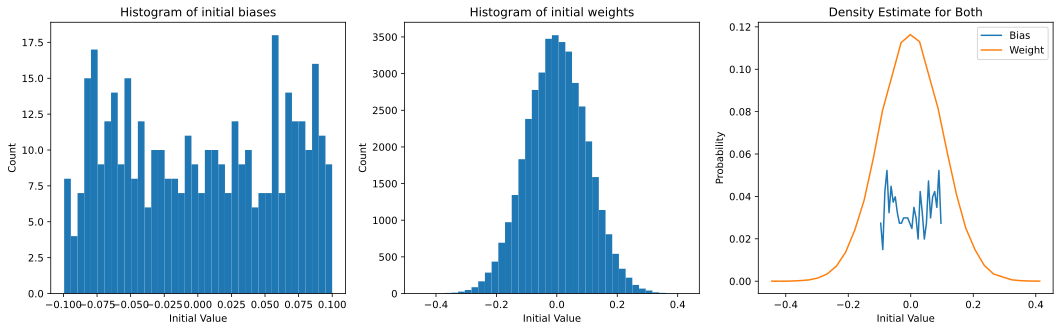

In [11]:
# Create their histograms
fig, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].hist(allbiases, 40)
ax[0].set_title("Histogram of initial biases")

ax[1].hist(allweight, 40)
ax[1].set_title("Histogram of initial weights")

# Collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2, yB/np.sum(yB), label="Bias")
ax[2].plot((xW[1:]+xW[:-1])/2, yW/np.sum(yW), label="Weight")
ax[2].set_title("Density Estimate for Both")
ax[2].legend()

# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial Value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")

plt.show()

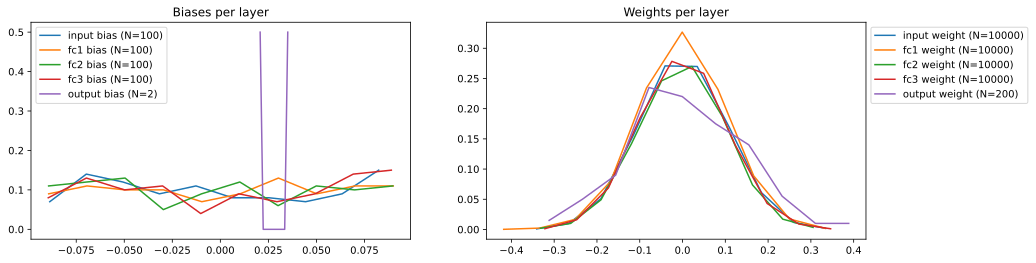

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():
    # get the data and compute their histogram
    thesedata = p[1].data.numpy().flatten()
    y,x = np.histogram(thesedata,10)

    # for the bias
    if 'bias' in p[0]:
        ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

    # for the weights
    elif 'weight' in p[0]:
        ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [13]:
# Let's see whether the numbers match our predictions from formula
# Empirical bias range
weightvar = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# Theoretical expected value
sigma = 2/ (weightcount + weightcount)

print(f"Theoretical Sigma: {sigma}")
print(f"Empirical Sigma: {weightvar}")

Theoretical Sigma: 0.01
Empirical Sigma: 0.010015204548835754


# Xavier vs Kaiming Performance

Build a FFNN usinf Wine Quality dataset where the weights are initialized either using Xavier or Kaiming, run it multiple times (min 10), do some visualization of the performance and run a statistical t-test to compare them.

In [14]:
# Download the data from original database
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep = ";")
# Remove the outlier
data = data[data["total sulfur dioxide"]<200]

# Normalize the data
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data["boolQuality"] = 0
data["boolQuality"][data["quality"] > 5] = 1
data.head()

<ipython-input-14-4e1a70d5ed73>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["boolQuality"][data["quality"] > 5] = 1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0


In [15]:
# Convert from Pandas to tensors
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()
# TRansform labels to matrix
labels = labels[:,None]

# Use sikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

# Convert to Pytorch Datasets
train_dataD = TensorDataset(train_data, train_labels)
test_dataD = TensorDataset(test_data, test_labels)

# Create the data loader objects
train_loader = DataLoader(train_dataD, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataD, batch_size=test_dataD.tensors[0].shape[0])

In [16]:
# Create model Class
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input Layer
        self.input = nn.Linear(11,16)

        # Two hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Output Layer
        self.output = nn.Linear(32,1)

    # Forward Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [17]:
# Define the number of trianing epoch
numepochs = 600

def trainTheModel(winenet):

    # Define loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=0.01)

    # Initialize the losses
    losses = torch.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Start fresh model instance
        # Define batch loss and accuracy
        winenet.train()
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this particular batch
            batchLoss.append(loss.item())

            # Training accuracy of the batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        # End of the batch loop

        # Training accuracy for the epoch
        trainAcc.append(np.mean(batchAcc))

        # Training losses for the epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test
        winenet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        
        # Test Accuracy and losses
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        losses[epochi,1] = lossfun(yHat,y).item()
    # End of epoch
    # Return everything at the end
    return trainAcc, testAcc, losses

In [22]:
# Initialize the weights and test the model
winenet_xavier = ANNwine()

# Change the weights: leave biases as Kaiming (the default)
for p in winenet_xavier.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_normal_(p[1].data)

# train the model and get the output
trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)

In [23]:
# Initialize the weights and test the model
winenet_kaiming = ANNwine()

# Change the weights: leave biases as Kaiming (the default)
# For learning purposes, and add an additional parameter for non-linearity: ReLU instead of Leaky ReLU
for p in winenet_kaiming.named_parameters():
    if "weight" in p[0]:
        nn.init.kaiming_normal_(p[1].data, nonlinearity="relu")

# train the model and get the output
trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)

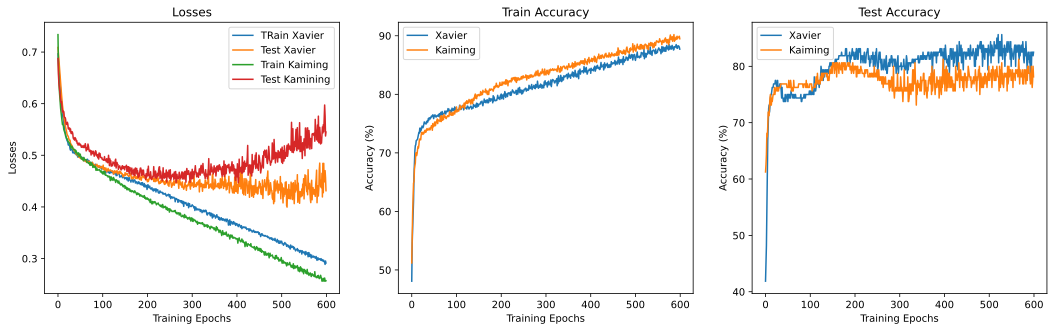

In [24]:
# Plot the results
fig,ax = plt.subplots(1,3, figsize=(18,5))

# Losses
ax[0].plot(losses_X)
ax[0].plot(losses_K)
ax[0].legend(["Train Xavier", "Test Xavier", "Train Kaiming", "Test Kamining"])
ax[0].set_title("Losses")
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Losses")

ax[1].plot(trainAcc_X, label="Xavier")
ax[1].plot(trainAcc_K, label="Kaiming")
ax[1].legend()
ax[1].set_title("Train Accuracy")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")

ax[2].plot(testAcc_X, label="Xavier")
ax[2].plot(testAcc_K, label="Kaiming")
ax[2].legend()
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Training Epochs")
ax[2].set_ylabel("Accuracy (%)")

plt.show()

In [33]:
# Run the experiment 10 times
numExp = 10

# Dimensions of results
# 1 - experimental run
# 2 - metric(loss/train/test)
# 3 - weight initialization (K/X)

results = np.zeros((numExp, 3, 2))

for expi in range(numExp):

    # Xavier
    winenet_xavier = ANNwine()

    # Change the weights: leave biases as Kaiming (the default)
    for p in winenet_xavier.named_parameters():
        if "weight" in p[0]:
            nn.init.xavier_normal_(p[1].data)

    # train the model and get the output
    trainAcc_X, testAcc_X, losses_X = trainTheModel(winenet_xavier)

    # Kaiming
    # Initialize the weights and test the model
    winenet_kaiming = ANNwine()

    # Change the weights: leave biases as Kaiming (the default)
    for p in winenet_kaiming.named_parameters():
        if "weight" in p[0]:
            nn.init.kaiming_normal_(p[1].data, nonlinearity="relu")

    # train the model and get the output
    trainAcc_K, testAcc_K, losses_K = trainTheModel(winenet_kaiming)

    # Collect the results
    results[expi,0,0] = torch.mean(losses_X[0][-5:]).item()
    results[expi,0,1] = torch.mean(losses_K[0][-5:]).item()

    results[expi,1,0] = np.mean(trainAcc_X[-5:])
    results[expi,1,1] = np.mean(trainAcc_K[-5:])

    results[expi,2,0] = np.mean(testAcc_X[-5:])
    results[expi,2,1] = np.mean(testAcc_K[-5:])

    print(f"Finished run: {expi+1}/{numExp}")

Finished run: 1/10
Finished run: 2/10
Finished run: 3/10
Finished run: 4/10
Finished run: 5/10
Finished run: 6/10
Finished run: 7/10
Finished run: 8/10
Finished run: 9/10
Finished run: 10/10


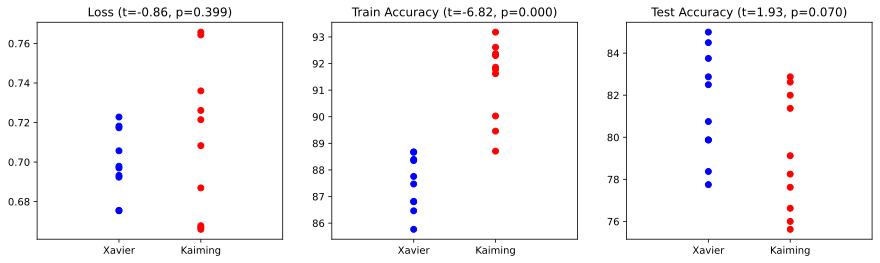

In [35]:
# Plot the whole thing
fig,ax = plt.subplots(1,3, figsize=(15,4))

# Titles
metric = ["Loss", "Train Accuracy", "Test Accuracy"]

for i in range(3):

    # PLot the results
    ax[i].plot(np.zeros(numExp), results[:,i,0], "bo")
    ax[i].plot(np.ones(numExp), results[:,i,1], "ro")

    # Run a t-test
    t,p = stats.ttest_ind(results[:,i,0], results[:,i,1])
    title = "%s (t=%.2f, p=%.3f)" %(metric[i], t, p)

    # Impove plot apparence
    ax[i].set_xlim([-1,2])
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(["Xavier", "Kaiming"])
    ax[i].set_title(title)

plt.show()

# Identically Random Weights

Create a small network using nn.Sequential() with 2 input units, one hidden layer of 8 units and an output unit of 1. Create four instances of the model with Xavier weight initialization:

1 - ne_noseed: No Random seed

2 - net_rs1a: Random seed = 1

3 - net_rs2: Random seed = 2

4 - net_rs1b: Random seed = 1

In [46]:
# Create the model
net = nn.Sequential(
    nn.Linear(2,8),
    nn.Linear(8,1),
    nn.Linear(1,1),
    )

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
  (2): Linear(in_features=1, out_features=1, bias=True)
)


In [47]:
# Load copy library for creating deep copies of the model to avoid copying the above model 4 times
import copy

# Create 4 networks
# No random seed

net_noseed = copy.deepcopy(net)

# Change the weights: leave biases as Kaiming (the default)
for p in net_noseed.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [48]:
# Radnom seed 1A
net_1a = copy.deepcopy(net)

# Set the seed to 1 again
torch.manual_seed(1)

# Change the weights: leave biases as Kaiming (the default)
for p in net_1a.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [49]:
# Radnom seed 1A
net_2 = copy.deepcopy(net)

# Set the seed to 2
torch.manual_seed(2)

# Change the weights: leave biases as Kaiming (the default)
for p in net_2.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [50]:
# Radnom seed 1B
net_1b = copy.deepcopy(net)

# Set the seed to 1 again
torch.manual_seed(1)

# Change the weights: leave biases as Kaiming (the default)
for p in net_1b.named_parameters():
    if "weight" in p[0]:
        nn.init.xavier_normal_(p[1].data)

In [51]:
# Get all the weights from the networks
w_ns = np.array([])
w_1a = np.array([])
w_2 = np.array([])
w_1b = np.array([])

for i in range(3):
    w_ns = np.append(w_ns, net_noseed[i].weight.view(-1).detach().numpy())
    w_1a = np.append(w_1a, net_1a[i].weight.view(-1).detach().numpy())
    w_2 = np.append(w_2, net_2[i].weight.view(-1).detach().numpy())
    w_1b = np.append(w_1b, net_1b[i].weight.view(-1).detach().numpy())

# Check one of them
w_1b

array([-0.68226725, -0.33551386, -0.29246914, -0.71978348, -0.04479612,
       -0.27243757, -0.43816748, -0.71960974, -0.31848076,  0.1358286 ,
       -0.34762552, -0.11245421, -0.09940238,  0.75450003,  0.10215484,
        0.20913295, -0.48441932, -0.26542562, -0.42062977, -0.0274594 ,
       -0.0921641 , -0.45520514,  0.19912849,  0.12601444, -0.42119515])

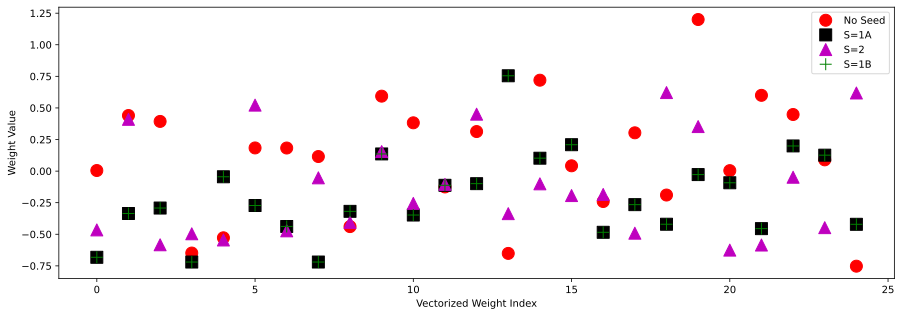

In [52]:
# Plot the whole thing
fig = plt.figure(figsize=(15,5))

plt.plot(w_ns, "ro", markersize=12, label="No Seed")
plt.plot(w_1a, "ks", markersize=12, label="S=1A")
plt.plot(w_2, "m^", markersize=12, label="S=2")
plt.plot(w_1b, "g+", markersize=12, label="S=1B")
plt.legend()
plt.xlabel("Vectorized Weight Index")
plt.ylabel("Weight Value")
plt.show()

# 1A and 1B are all aligned

In [53]:
# Use an algebraic test
print("1A - 1B Should be zero")
print(w_1a - w_1b)

1A - 1B Should be zero
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [54]:
print("1A - 2 should not be all zeros")
print(w_1a - w_2)

1A - 2 should not be all zeros
[-0.21680683 -0.74543169  0.29078251 -0.22352022  0.50025801 -0.79460078
  0.03471264 -0.66646316  0.08751756 -0.01855947 -0.09211725 -0.0073103
 -0.55001713  1.09119886  0.20277754  0.40263602 -0.29967313  0.22609788
 -1.04223195 -0.37989978  0.53314489  0.12994796  0.2475912   0.57373706
 -1.03930008]


In [55]:
print("1B - 2 Should also not be all zeros")
print(w_1b - w_2)

1B - 2 Should also not be all zeros
[-0.21680683 -0.74543169  0.29078251 -0.22352022  0.50025801 -0.79460078
  0.03471264 -0.66646316  0.08751756 -0.01855947 -0.09211725 -0.0073103
 -0.55001713  1.09119886  0.20277754  0.40263602 -0.29967313  0.22609788
 -1.04223195 -0.37989978  0.53314489  0.12994796  0.2475912   0.57373706
 -1.03930008]
